#### EE555 - Final Project
###### Jonathan Day, Laura Rackley, and Anna Ptasznik
###### Professor: Baosen Zhang
###### TA: Daniel Tabas

The following notebook outlines an attempt to create a Neural Network model that predicts the load consumption for various European Countries. This network is trained on historical load data, gross domestic product (GDP), weather data and population.  

In [24]:
# Importing necesarry functions (and then some) for debugging and calculations

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import traceback
import sqlalchemy as sqla
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from copy import deepcopy
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')

# This function performs one iteration of gradient descent to improve the model parameters
def train_loop(net,loss_fn,optimizer,X_train,Y_train):
    pred = net(X_train) # this calls the net.forward function, returning one prediction for each row of X.
    loss = loss_fn(pred, Y_train) # compute the loss associated with the predictions
    loss_traj.append(loss) # Record the loss at each iteration

    # Gradient descent
    optimizer.zero_grad() # Reset the gradients to zero
    loss.backward() # Compute the gradient of the loss with respect to each weight in the network
    optimizer.step() # Take a gradient step

In [15]:
df = pd.read_csv('load_per_country.csv', parse_dates=['DateTime'], index_col = ['DateTime'])
gdp = pd.read_csv('gdp_per_country.csv', parse_dates=['DateTime'], index_col = ['DateTime'])
pop = pd.read_csv('population_per_country.csv', parse_dates=['DateTime'], index_col = ['DateTime'])
tmp =  pd.read_csv('tmp_per_country.csv', parse_dates=['DateTime'], index_col = ['DateTime'])

joined = df.join(gdp, on='DateTime', how='left', lsuffix = '', rsuffix = '_GDP', sort=False)
joined = joined.join(pop, on='DateTime', how='left', lsuffix = '', rsuffix = '_POP', sort=False)
joined = joined.join(tmp, on='DateTime', how='left', lsuffix = '', rsuffix = '_TMP', sort=False)
joined = joined.replace(',','', regex=True)
joined_interpolate = joined.interpolate(method='ffill') # or method='index' works too

In [34]:
# This code extracts DE data for use in training and testing. 

country_datasets = []
datasets = []
country_list = ['PL', 'DE']

for country in country_list:
    country_dataset = joined_interpolate[[country, country + '_GDP', country+ '_POP', country+'_TMP']]
    country_datasets.append([deepcopy(country_datasets), deepcopy(country_dataset)])

for each in country_datasets:
    name = each[0]
    dataset = each[1]
    datasets.append([deepcopy(dataset), deepcopy(datasets)])\
    
select_2012 = joined_interpolate.loc['2012-01-01':'2014-12-31'] #Subset through to the last year, using the last year for testing
nonan = select_2012.dropna()
nonan = nonan.groupby(pd.Grouper(level='DateTime', axis=0, freq='M')).sum()

# normalize - might cause data with other testing data
nonan = nonan / nonan.max(axis=0) # 

x_trainDE, x_testDE, y_trainDE, y_testDE = train_test_split(nonan.iloc[:, :1].values, nonan['DE'].values,test_size=0.2)

X_train_torchDE = torch.tensor(x_trainDE).float()
Y_train_torchDE = torch.tensor(y_trainDE).float()
X_test_torchDE = torch.tensor(x_testDE).float()
Y_test_torchDE = torch.tensor(y_testDE).float()

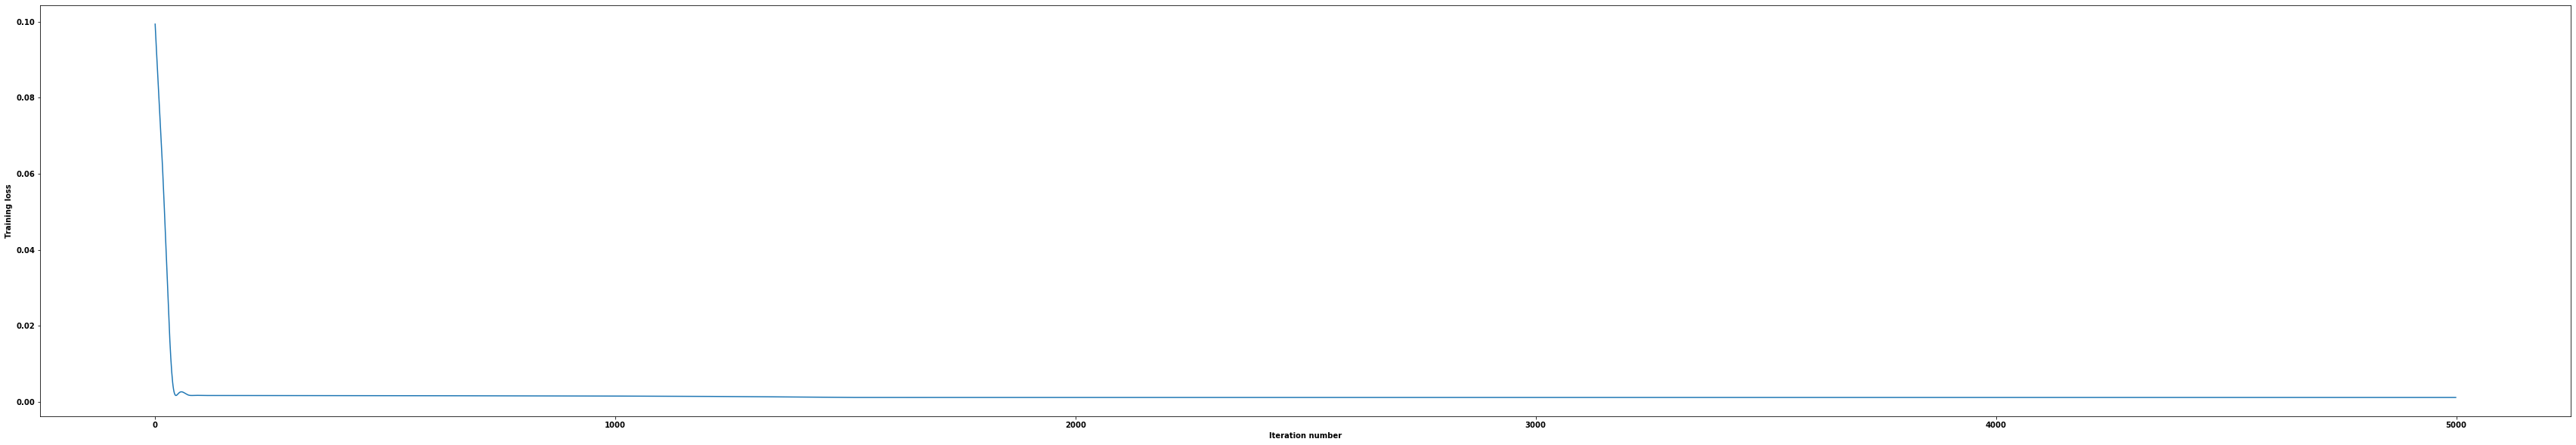

In [35]:
n_pmu = X_train_torchDE.shape[1]

# Neural network class:
class fault_net(nn.Module): 
    def __init__(self,n_hidden): # Passing the parameter n_hidden to the __init__ function allows us to customize the width of the network
        super(fault_net, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(n_pmu,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,1),
        )

    def forward(self, x): 
        return torch.sigmoid(self.model(x)) # Sigmoid clamps the output between 0 and 1 for binary classification
    
# Loss function
loss_fn = nn.MSELoss() 

n_hidden = 34 # The width of each hidden layer in the network, represents CSV data length or amount of countries 
net = fault_net(n_hidden) # Create neural network of width n_hidden

# Create an 'optimizer' object for training:
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

loss_traj = []
    
# Iterate through T = 5000 times for training
T = 5000
for t in range(T):
    train_loop(net,loss_fn,optimizer,X_train_torchDE,Y_train_torchDE.unsqueeze(1))
    

Y_hat_trainDE = net(X_train_torchDE) #Y DE training data prediction
Y_hat_testDE = net(X_test_torchDE) ##Y DE test data prediction

# The following code allows the tesnor of loss_traj to be plotted
loss_traj2 = []
for i in range(len(loss_traj)):
    a = loss_traj[i].detach()
    loss_traj2.append(a)
plt.plot(loss_traj2)
#plt.plot(loss_traj) does not work
plt.xlabel('Iteration number')
plt.ylabel('Training loss');

#Extracting for plotting predition data of traning DE
y_predDE = []
for i in range(len(Y_hat_trainDE)):
    a = Y_hat_trainDE[i].detach()
    y_predDE.append(a)
#Extracting for plotting predition data of testing DE
y_testDE = []
for i in range(len(Y_hat_testDE)):
    #print(loss_traj[i])
    a = Y_hat_testDE[i].detach()
    y_testDE.append(a)

In [36]:
Y_hat_train = nn.functional.log_softmax(Y_hat_trainDE, dim=0)
Y_train = nn.functional.log_softmax(Y_train_torchDE, dim=0)
loss = nn.KLDivLoss(reduction='batchmean',  log_target=True)(Y_hat_train ,Y_train)
print(loss)

tensor(0.0013, grad_fn=<DivBackward0>)


Based on the Sklearn provided loss calculation for a multivariable Neural Network, the training loss for the network is about 0.13%. The next plots will show the predictions for the training, testing, and future data. 

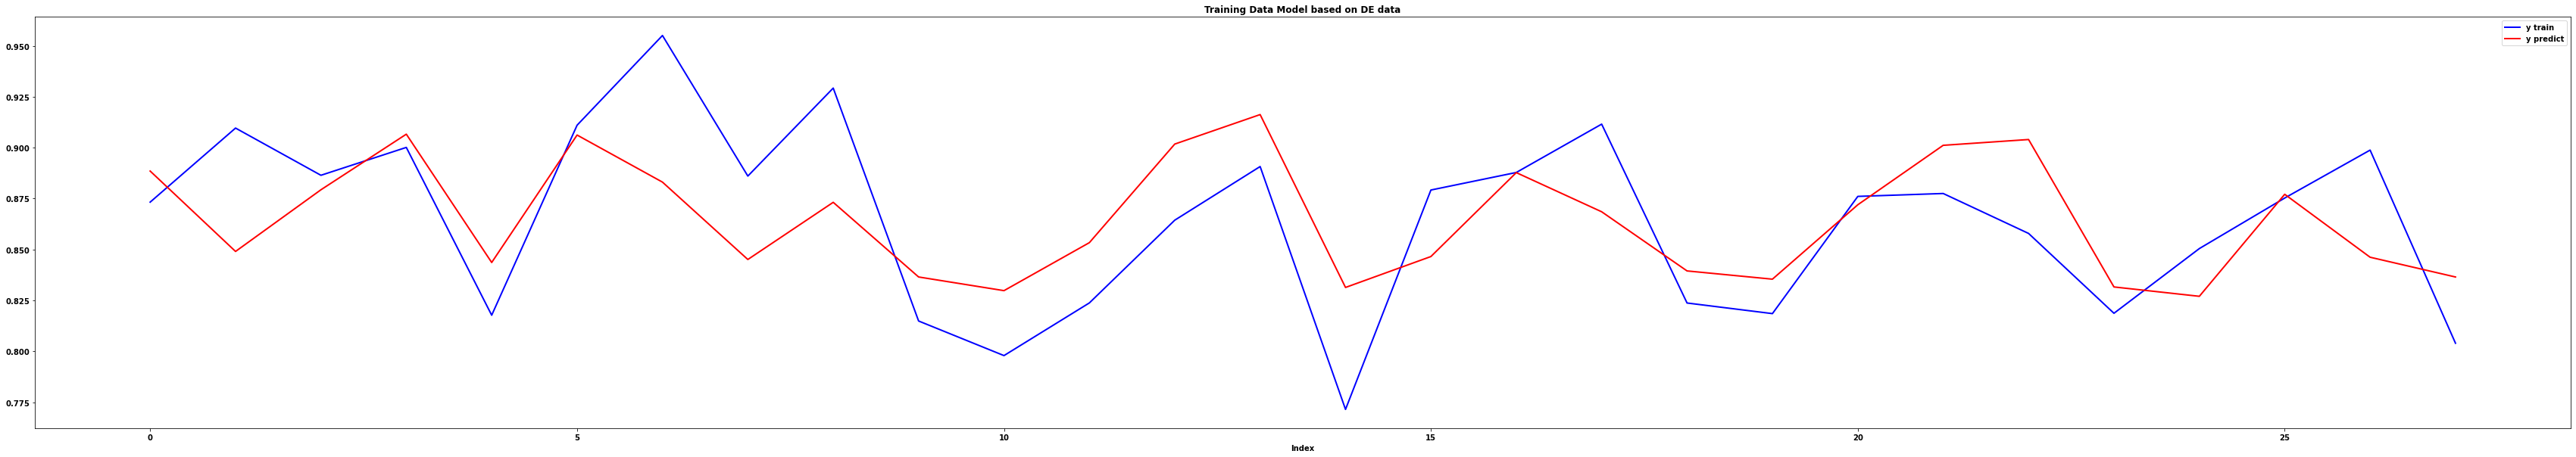

In [37]:
plt.plot( Y_train_torchDE, lw=2, color="blue", label="y train")
plt.plot( y_predDE, lw=2, color="red", label="y predict")
plt.legend()
plt.title("Training Data Model based on DE data")
plt.xlabel("Index")
plt.rcParams["figure.figsize"] = (60,10)
plt.show()

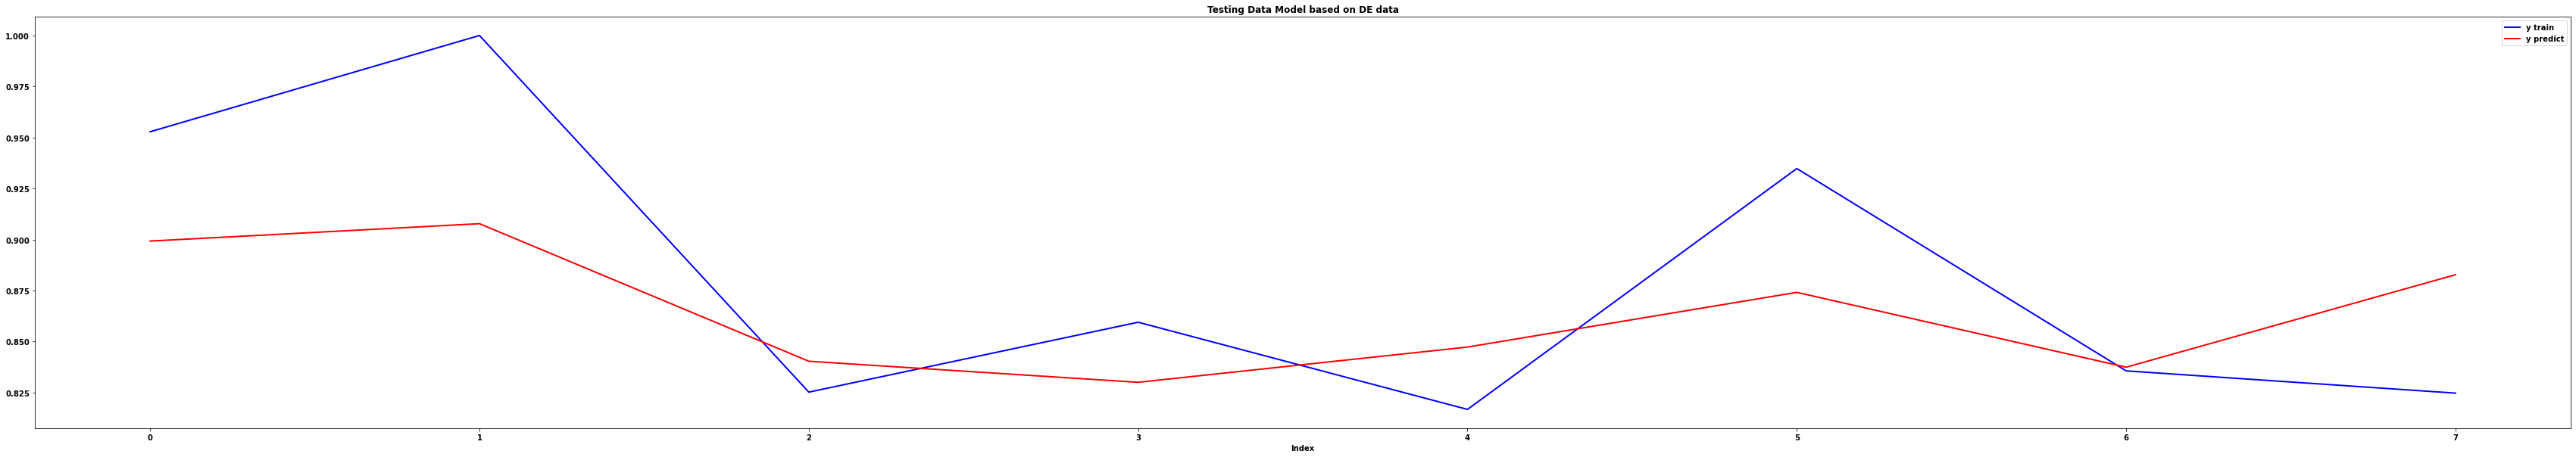

In [38]:
plt.plot( Y_test_torchDE, lw=2, color="blue", label="y train")
plt.plot( y_testDE, lw=2, color="red", label="y predict")
plt.legend()
plt.title("Testing Data Model based on DE data")
plt.xlabel("Index")
plt.rcParams["figure.figsize"] = (60,10)
plt.show()

In [39]:
Y_hat_train = nn.functional.log_softmax(Y_test_torchDE, dim=0)
Y_train = nn.functional.log_softmax(Y_hat_testDE, dim=0)
loss = nn.KLDivLoss(reduction='batchmean',  log_target=True)(Y_hat_train ,Y_train)
print(loss)

tensor(0.0026, grad_fn=<DivBackward0>)


The next section tests PL data against the model constructed above

In [31]:
country_datasets = []
datasets = []
country_list = ['LT', 'PL']

for country in country_list:
    country_dataset = joined_interpolate[[country, country + '_GDP', country+ '_POP', country+'_TMP']]
    country_datasets.append([deepcopy(country_datasets), deepcopy(country_dataset)])

for each in country_datasets:
    name = each[0]
    dataset = each[1]
    datasets.append([deepcopy(dataset), deepcopy(datasets)])\
    
select_2012 = joined_interpolate.loc['2012-01-01':'2014-12-31'] #Subset through to the last year, using the last year for testing
nonan = select_2012.dropna()
nonan = nonan.groupby(pd.Grouper(level='DateTime', axis=0, freq='M')).sum()

# normalize - might cause data with other testing data
nonan = nonan / nonan.max(axis=0) # 

X_traintorchPL = torch.tensor(nonan.iloc[:, 1:2].values).float() #Extracting PL
YtrainPL = net(X_traintorchPL)
#YtestDE = net(X_test_torchDE)

yPL = []
for i in range(len(YtrainPL)):
    a = YtrainPL[i].detach()
    yPL.append(a)

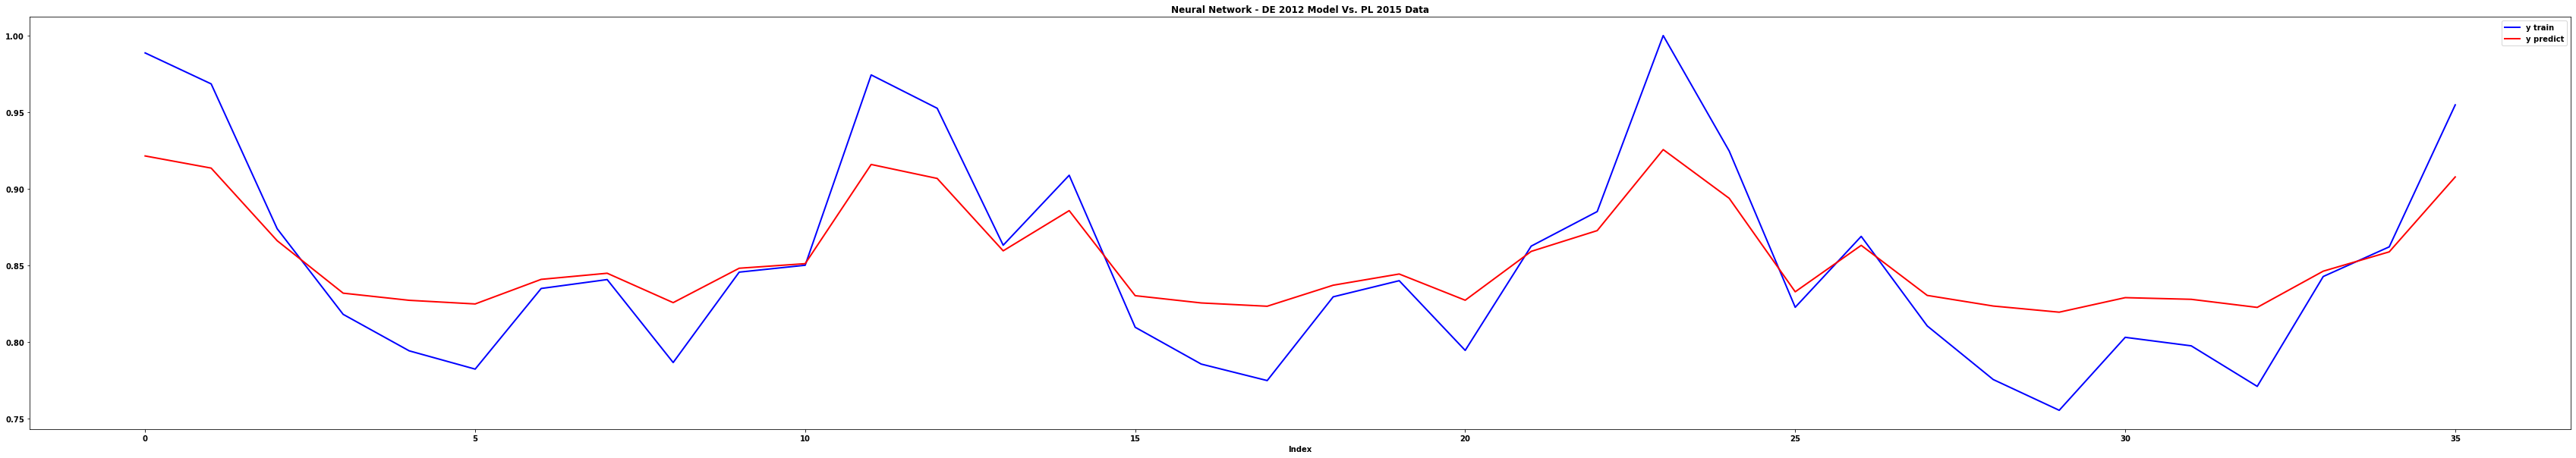

In [40]:
plt.plot( X_traintorchPL, lw=2, color="blue", label="y train")
plt.plot( yPL, lw=2, color="red", label="y predict")
plt.legend()
plt.title("Neural Network - DE 2012 Model Vs. PL 2012 Data")
plt.xlabel("Index")
plt.rcParams["figure.figsize"] = (60,10)
plt.show()

In [41]:
Y_hat_train = nn.functional.log_softmax(X_traintorchPL, dim=0)
Y_train = nn.functional.log_softmax(YtrainPL, dim=0)
loss = nn.KLDivLoss(reduction='batchmean',  log_target=True)(Y_hat_train ,Y_train)
print(loss)

tensor(1.7264e-05, grad_fn=<DivBackward0>)


Based on normalized data, this model has high accuracy for future prediction data.

The following code extracts the 2015 data for testing on the net constructed above.

In [42]:
df = pd.read_csv('load_per_country.csv', parse_dates=['DateTime'], index_col = ['DateTime'])
select = df[['DE','PL']]

select_2015 = select.loc['2015-01-01':'2015-12-31']


nonan = select_2015.dropna()
nonan = nonan.groupby(pd.Grouper(level='DateTime', axis=0, freq='24H')).sum()
#print(nonan)

nonan = nonan / nonan.max(axis=0)
#print(nonan)

#x_trainDE, x_testDE, y_trainDE, y_testDE = train_test_split(nonan.iloc[:, :1].values, nonan['DE'].values,test_size=0.2)


X_traintorchPL = torch.tensor(nonan.iloc[:, 1:2].values).float()
YtrainPL = net(X_traintorchPL)
#YtestDE = net(X_test_torchDE)

yPL = []
for i in range(len(YtrainPL)):
    #print(loss_traj[i])
    a = YtrainPL[i].detach()
    yPL.append(a)

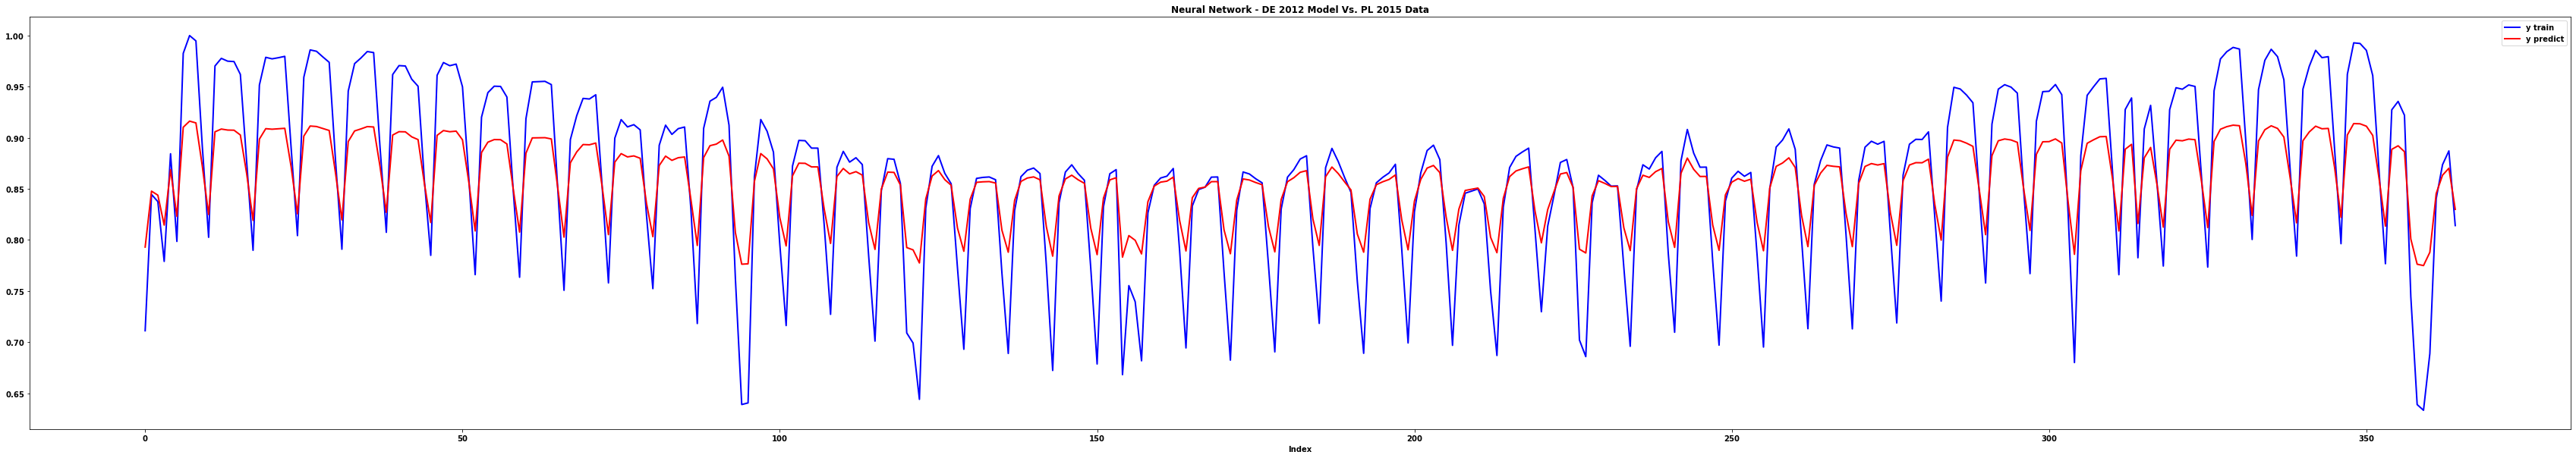

In [50]:
plt.plot( X_traintorchPL, lw=2, color="blue", label="y train")
plt.plot( yPL, lw=2, color="red", label="y predict")
plt.legend()
plt.title("Neural Network - DE 2012 Model Vs. PL 2015 Data")
plt.xlabel("Index")
plt.rcParams["figure.figsize"] = (60,10)
plt.show()

In [51]:
Y_hat_train = nn.functional.log_softmax(X_traintorchPL, dim=0)
Y_train = nn.functional.log_softmax(YtrainPL, dim=0)
loss = nn.KLDivLoss(reduction='batchmean',  log_target=True)(Y_hat_train ,Y_train)
print(loss)

tensor(2.9487e-06, grad_fn=<DivBackward0>)


The following code tests the model created above on BG (Bulgaria) data

In [58]:
country_datasets = []
datasets = []
country_list = ['PL', 'BG']

for country in country_list:
    country_dataset = joined_interpolate[[country, country + '_GDP', country+ '_POP', country+'_TMP']]
    country_datasets.append([deepcopy(country_datasets), deepcopy(country_dataset)])

for each in country_datasets:
    name = each[0]
    dataset = each[1]
    datasets.append([deepcopy(dataset), deepcopy(datasets)])\
    
select_2012 = joined_interpolate.loc['2012-01-01':'2014-12-31'] #Subset through to the last year, using the last year for testing
nonan = select_2012.dropna()
nonan = nonan.groupby(pd.Grouper(level='DateTime', axis=0, freq='M')).sum()

# normalize - might cause data with other testing data
nonan = nonan / nonan.max(axis=0) # 

X_traintorchBG = torch.tensor(nonan.iloc[:, 1:2].values).float() #Extracting PL
YtrainBG = net(X_traintorchBG)
#YtestDE = net(X_test_torchDE)

yBG = []
for i in range(len(YtrainBG)):
    a = YtrainBG[i].detach()
    yBG.append(a)

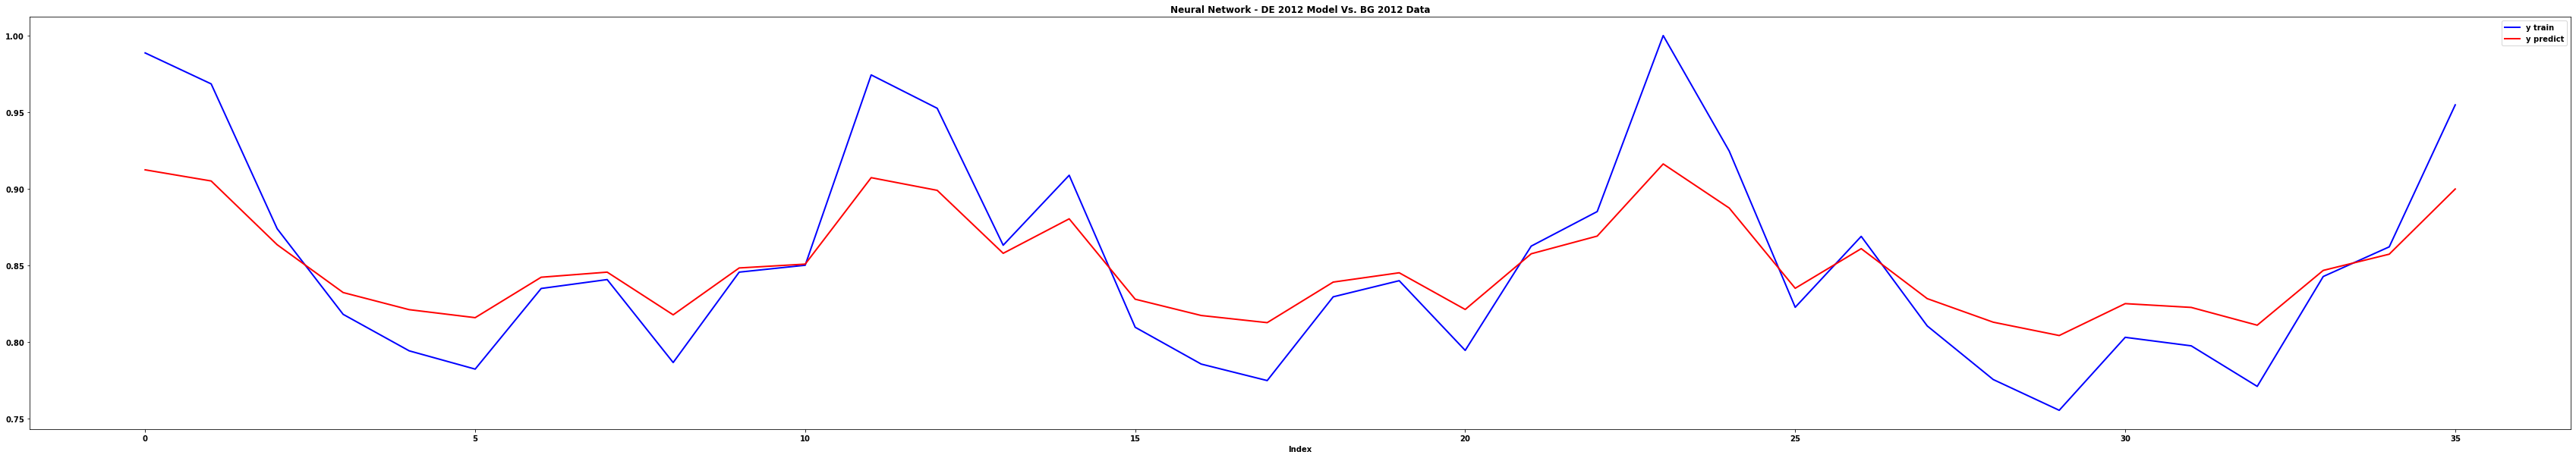

In [60]:
plt.plot( X_traintorchLT, lw=2, color="blue", label="y train")
plt.plot( yLT, lw=2, color="red", label="y predict")
plt.legend()
plt.title("Neural Network - DE 2012 Model Vs. BG 2012 Data")
plt.xlabel("Index")
plt.rcParams["figure.figsize"] = (60,10)
plt.show()

In [61]:
Y_hat_train = nn.functional.log_softmax(X_traintorchBG, dim=0)
Y_train = nn.functional.log_softmax(YtrainBG, dim=0)
loss = nn.KLDivLoss(reduction='batchmean',  log_target=True)(Y_hat_train ,Y_train)
print(loss)

tensor(1.7360e-05, grad_fn=<DivBackward0>)


The following code tests Germany data without GDP to show significance of that variable

In [63]:
country_datasets = []
datasets = []
country_list = ['PL', 'DE']

for country in country_list:
    country_dataset = joined_interpolate[[country, country+ '_POP', country+'_TMP']]
    country_datasets.append([deepcopy(country_datasets), deepcopy(country_dataset)])

for each in country_datasets:
    name = each[0]
    dataset = each[1]
    datasets.append([deepcopy(dataset), deepcopy(datasets)])\
    
select_2012 = joined_interpolate.loc['2012-01-01':'2014-12-31'] #Subset through to the last year, using the last year for testing
nonan = select_2012.dropna()
nonan = nonan.groupby(pd.Grouper(level='DateTime', axis=0, freq='M')).sum()

# normalize - might cause data with other testing data
nonan = select_2012.dropna()
nonan = nonan.groupby(pd.Grouper(level='DateTime', axis=0, freq='M')).sum()

# normalize - might cause data with other testing data
nonan = nonan / nonan.max(axis=0) # 

x_trainDE, x_testDE, y_trainDE, y_testDE = train_test_split(nonan.iloc[:, :1].values, nonan['DE'].values,test_size=0.2)

X_train_torchDE = torch.tensor(x_trainDE).float()
Y_train_torchDE = torch.tensor(y_trainDE).float()
X_test_torchDE = torch.tensor(x_testDE).float()
Y_test_torchDE = torch.tensor(y_testDE).float()

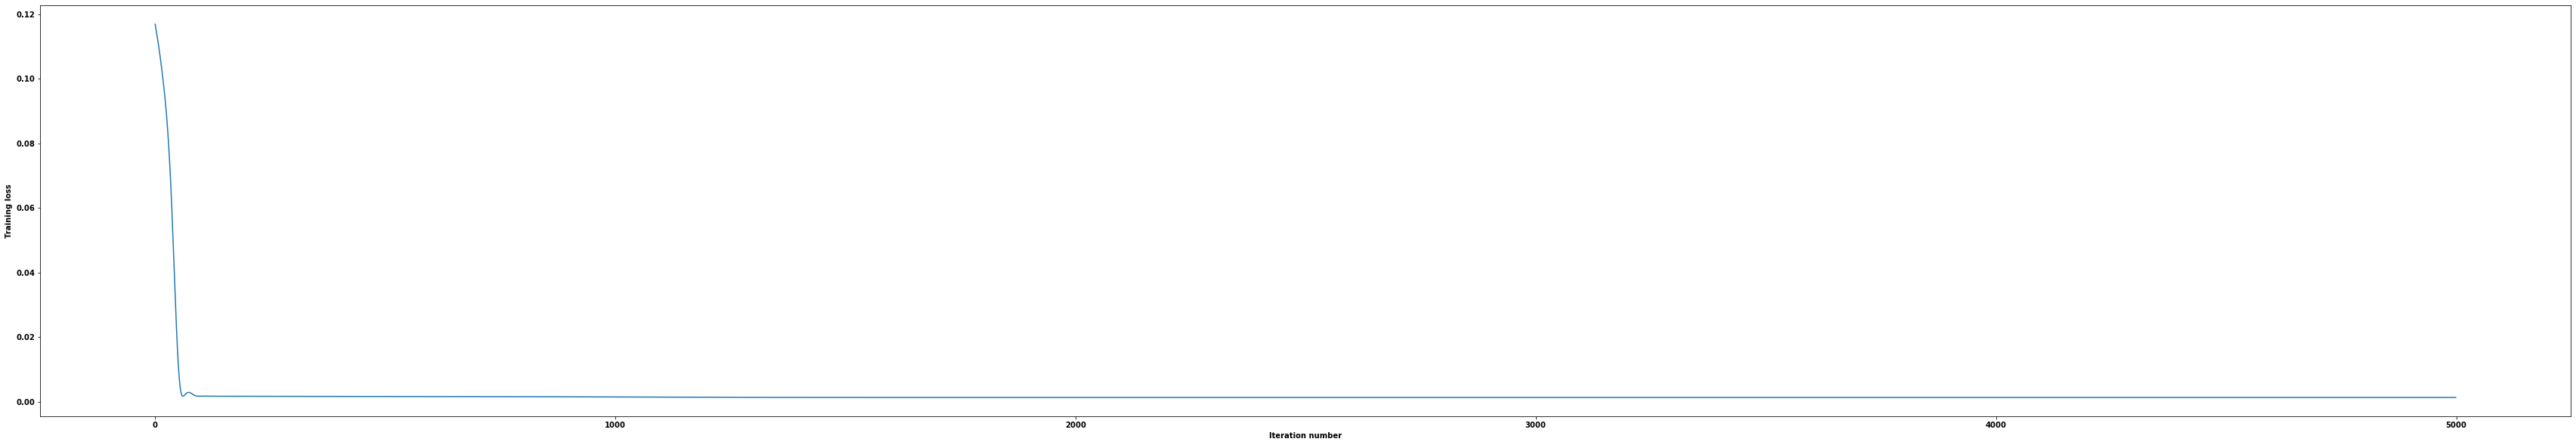

In [64]:
n_pmu = X_train_torchDE.shape[1]

# Neural network class:
class fault_net(nn.Module): 
    def __init__(self,n_hidden): # Passing the parameter n_hidden to the __init__ function allows us to customize the width of the network
        super(fault_net, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(n_pmu,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,1),
        )

    def forward(self, x): 
        return torch.sigmoid(self.model(x)) # Sigmoid clamps the output between 0 and 1 for binary classification
    
# Loss function
loss_fn = nn.MSELoss() 

n_hidden = 34 # The width of each hidden layer in the network, represents CSV data length or amount of countries 
net = fault_net(n_hidden) # Create neural network of width n_hidden

# Create an 'optimizer' object for training:
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

loss_traj = []
    
# Iterate through T = 5000 times for training
T = 5000
for t in range(T):
    train_loop(net,loss_fn,optimizer,X_train_torchDE,Y_train_torchDE.unsqueeze(1))
    

Y_hat_trainDE = net(X_train_torchDE) #Y DE training data prediction
Y_hat_testDE = net(X_test_torchDE) ##Y DE test data prediction

# The following code allows the tesnor of loss_traj to be plotted
loss_traj2 = []
for i in range(len(loss_traj)):
    a = loss_traj[i].detach()
    loss_traj2.append(a)
plt.plot(loss_traj2)
#plt.plot(loss_traj) does not work
plt.xlabel('Iteration number')
plt.ylabel('Training loss');

#Extracting for plotting predition data of traning DE
y_predDE = []
for i in range(len(Y_hat_trainDE)):
    a = Y_hat_trainDE[i].detach()
    y_predDE.append(a)
#Extracting for plotting predition data of testing DE
y_testDE = []
for i in range(len(Y_hat_testDE)):
    #print(loss_traj[i])
    a = Y_hat_testDE[i].detach()
    y_testDE.append(a)

In [65]:
Y_hat_train = nn.functional.log_softmax(Y_hat_trainDE, dim=0)
Y_train = nn.functional.log_softmax(Y_train_torchDE, dim=0)
loss = nn.KLDivLoss(reduction='batchmean',  log_target=True)(Y_hat_train ,Y_train)
print(loss)

tensor(0.0014, grad_fn=<DivBackward0>)


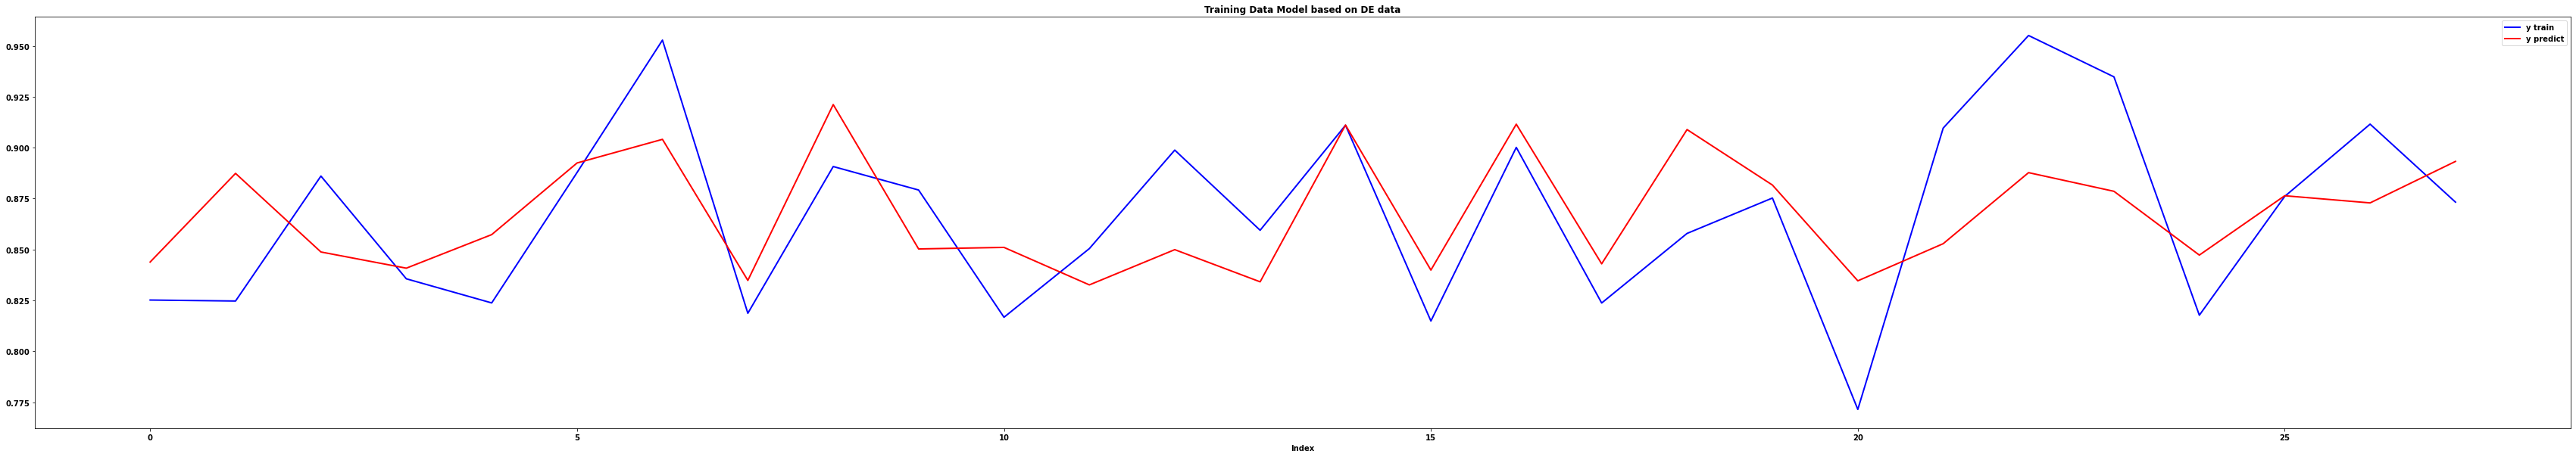

In [66]:
plt.plot( Y_train_torchDE, lw=2, color="blue", label="y train")
plt.plot( y_predDE, lw=2, color="red", label="y predict")
plt.legend()
plt.title("Training Data Model based on DE data")
plt.xlabel("Index")
plt.rcParams["figure.figsize"] = (60,10)
plt.show()